In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
# 규원님이 전처리 완료하신 최종 데이터 (+라벨까지 붙은)
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/deeplearning_NLP/perfume/cnn_classification/data/dataset_210626_215600.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
len(df)

74779

In [ ]:
df.head()

,gender,name,accords,review,tokenized,only_english,longer_than_2_A,stopwords_removed,lemmatizated,label
0,female,Alien Mugler for women,"['white floral', 'amber', 'woody']","Got a sample of this today, and my 9 year old ...","['got', 'a', 'sample', 'of', 'this', 'today', ...","['got', 'a', 'sample', 'of', 'this', 'today', ...","['got', 'sample', 'this', 'today', 'and', 'yea...","['got', 'sample', 'today', 'year', 'old', 'dau...","['get', 'sample', 'today', 'year', 'old', 'dau...",2.0
1,female,Alien Mugler for women,"['white floral', 'amber', 'woody']",First impressions. Test on blotter.\r\nI have ...,"['first', 'impressions.', 'test', 'on', 'blott...","['first', 'impressions', 'test', 'on', 'blotte...","['first', 'impressions', 'test', 'blotter', 'h...","['first', 'impressions', 'test', 'blotter', 'h...","['first', 'impression', 'test', 'blotter', 'he...",2.0
2,female,Alien Mugler for women,"['white floral', 'amber', 'woody']",This perfume reminds me of my best friend. Act...,"['this', 'perfume', 'reminds', 'me', 'of', 'my...","['this', 'perfume', 'reminds', 'me', 'of', 'my...","['this', 'perfume', 'reminds', 'best', 'friend...","['perfume', 'reminds', 'best', 'friend', 'actu...","['perfume', 'reminds', 'best', 'friend', 'actu...",2.0
3,female,Alien Mugler for women,"['white floral', 'amber', 'woody']",Imagine tripping over your own feet and fallin...,"['imagine', 'tripping', 'over', 'your', 'own',...","['imagine', 'tripping', 'over', 'your', 'own',...","['imagine', 'tripping', 'over', 'your', 'own',...","['imagine', 'tripping', 'feet', 'falling', 'fa...","['imagine', 'trip', 'foot', 'fall', 'face', 'f...",2.0
4,female,Alien Mugler for women,"['white floral', 'amber', 'woody']",Gorgeous Gorgeous Blend ..\r\nLove the scent.....,"['gorgeous', 'gorgeous', 'blend', '..', 'love'...","['gorgeous', 'gorgeous', 'blend', '', 'love', ...","['gorgeous', 'gorgeous', 'blend', 'love', 'the...","['gorgeous', 'gorgeous', 'blend', 'love', 'sce...","['gorgeous', 'gorgeous', 'blend', 'love', 'sce...",2.0


**단어 기반 인코딩 후 텍스트를 정수 시퀀스로 변환**

**+ 빈도가 높은 단어만 사용**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

X_data = df['lemmatizated']
y_data = df['label']

# 단어 기반 인코딩
tokenizer = Tokenizer(oov_token="<OOV>") # 미리 인덱싱하지 않은 단어들은 ‘<OOV>’로 인덱싱
tokenizer.fit_on_texts(X_data) #문자 데이터를 입력받아서 리스트의 형태로 변환
word_index = tokenizer.word_index


# 텍스트를 정수 시퀀스로 변환하기
sequences = tokenizer.texts_to_sequences(X_data)

print(word_index)
print('전체 단어 개수 : ', len(word_index))
print(sequences[0:5])

{'<OOV>': 1, "'smell'": 2, "'like'": 3, "'scent'": 4, "'fragrance'": 5, "n't": 6, "'get'": 7, "'love'": 8, "'wear'": 9, "'note'": 10, "'perfume'": 11, "'bottle'": 12, "'sweet'": 13, "'really'": 14, "'think'": 15, "'time'": 16, "'would'": 17, "'say'": 18, "'well'": 19, "'skin'": 20, "'make'": 21, "'first'": 22, "'buy'": 23, "'hour'": 24, "'much'": 25, "'spray'": 26, "'day'": 27, "'last'": 28, "'try'": 29, "'vanilla'": 30, "'still'": 31, "'even'": 32, "'people'": 33, "'longevity'": 34, "'feel'": 35, "'something'": 36, "'want'": 37, "'strong'": 38, "'find'": 39, "'give'": 40, "'great'": 41, "'could'": 42, "'also'": 43, "'know'": 44, "'way'": 45, "'use'": 46, "'fresh'": 47, "'come'": 48, "'dry'": 49, "'nice'": 50, "'bit'": 51, "'long'": 52, "'many'": 53, "'little'": 54, "'year'": 55, "'ve": 56, "'definitely'": 57, "'open'": 58, "'sillage'": 59, "'review'": 60, "'work'": 61, "'beautiful'": 62, "'see'": 63, "'best'": 64, "'woman'": 65, "'quite'": 66, "'lot'": 67, "'warm'": 68, "'never'": 69,

단어의 최소 빈도 : 1
단어의 최대 빈도 : 71106
단어의 평균 빈도 : 45.333208556149735
단어 빈도 Q1, Q2, Q3: 1.0, 1.0, 4.0


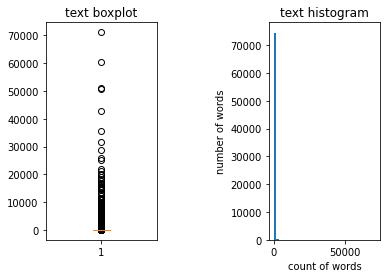

In [ ]:
# 단어 빈도 분포 확인
word_count = [tokenizer.word_counts[w] for w in tokenizer.word_counts.keys()]
word_count_s = pd.Series(word_count)

print('단어의 최소 빈도 : {}'.format(np.min(word_count)))
print('단어의 최대 빈도 : {}'.format(np.max(word_count)))
print('단어의 평균 빈도 : {}'.format(np.mean(word_count)))

print('단어 빈도 Q1, Q2, Q3: {}, {}, {}'.format(word_count_s.quantile(.25), word_count_s.quantile(.50), word_count_s.quantile(.75)))

plt.subplot(1,2,1)
plt.boxplot(word_count)
plt.title('text boxplot')
plt.subplots_adjust(wspace=1)
plt.subplot(1,2,2)
plt.title('text histogram')
plt.hist(word_count, bins=40)
plt.xlabel('count of words')
plt.ylabel('number of words')
plt.show()

In [ ]:
def below_threshold_count(max_cnt, word_dict):
  cnt = 0
  for w in word_dict.keys():
    if(word_dict[w] >= max_cnt):
        cnt = cnt + 1
  print('전체 단어 중 빈도가 %s 이상인 단어의 개수: %s / 전체에서 차지하는 비율 : %s'%(max_cnt, cnt, (cnt / len(word_dict))))

below_threshold_count(1, tokenizer.word_counts)
below_threshold_count(2, tokenizer.word_counts)
below_threshold_count(3, tokenizer.word_counts)

전체 단어 중 빈도가 1 이상인 단어의 개수: 74800 / 전체에서 차지하는 비율 : 1.0
전체 단어 중 빈도가 2 이상인 단어의 개수: 31761 / 전체에서 차지하는 비율 : 0.42461229946524065
전체 단어 중 빈도가 3 이상인 단어의 개수: 22872 / 전체에서 차지하는 비율 : 0.3057754010695187


In [ ]:
# 빈도 상위 30000개만 사용하여 다시 토큰화
num_words = 30000

# 단어 기반 인코딩
tokenizer = Tokenizer(num_words = num_words) # 미리 인덱싱하지 않은 단어들은 ‘<OOV>’로 인덱싱
tokenizer.fit_on_texts(X_data) #문자 데이터를 입력받아서 리스트의 형태로 변환
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= num_words} # <= because tokenizer is 1 indexed

# 텍스트를 정수 시퀀스로 변환하기
sequences = tokenizer.texts_to_sequences(X_data)

print(tokenizer.word_index)
print('전체 단어 개수 : ', len(tokenizer.word_index))
print(sequences[0:5])

{"'smell'": 1, "'like'": 2, "'scent'": 3, "'fragrance'": 4, "n't": 5, "'get'": 6, "'love'": 7, "'wear'": 8, "'note'": 9, "'perfume'": 10, "'bottle'": 11, "'sweet'": 12, "'really'": 13, "'think'": 14, "'time'": 15, "'would'": 16, "'say'": 17, "'well'": 18, "'skin'": 19, "'make'": 20, "'first'": 21, "'buy'": 22, "'hour'": 23, "'much'": 24, "'spray'": 25, "'day'": 26, "'last'": 27, "'try'": 28, "'vanilla'": 29, "'still'": 30, "'even'": 31, "'people'": 32, "'longevity'": 33, "'feel'": 34, "'something'": 35, "'want'": 36, "'strong'": 37, "'find'": 38, "'give'": 39, "'great'": 40, "'could'": 41, "'also'": 42, "'know'": 43, "'way'": 44, "'use'": 45, "'fresh'": 46, "'come'": 47, "'dry'": 48, "'nice'": 49, "'bit'": 50, "'long'": 51, "'many'": 52, "'little'": 53, "'year'": 54, "'ve": 55, "'definitely'": 56, "'open'": 57, "'sillage'": 58, "'review'": 59, "'work'": 60, "'beautiful'": 61, "'see'": 62, "'best'": 63, "'woman'": 64, "'quite'": 65, "'lot'": 66, "'warm'": 67, "'never'": 68, "'compliment

In [ ]:
len([6, 72, 170, 54, 93, 1439, 14, 1, 25, 1027, 1892, 3407, 824, 888, 463, 107, 185, 31, 309, 39, 1190, 3248, 25, 5843, 2495, 2415, 3407, 1, 15, 6, 1472, 50, 4902, 80, 2482, 3, 158, 666, 255, 320, 123, 1181, 108, 67, 152, 1439, 621, 31, 263, 191, 4, 1, 1389, 336, 463, 413, 46, 108, 175, 303, 521, 218, 168, 44, 1690, 349, 312, 895, 432, 474, 39, 28, 350, 22, 179, 11])

76

**패딩 설정하기**
1. 먼저 문장 길이의 분포를 확인
2. 적절한 패딩길이 설정

샘플의 최소 길이 : 0
샘플의 최대 길이 : 983
샘플의 평균 길이 : 44.72326455288249


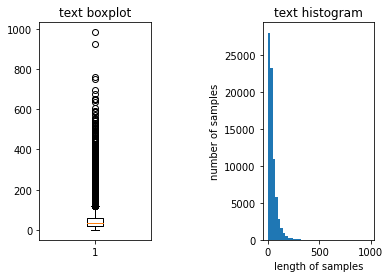

In [ ]:
# 길이 분포 출력
text_len = [len(l) for l in sequences]

print('샘플의 최소 길이 : {}'.format(np.min(text_len)))
print('샘플의 최대 길이 : {}'.format(np.max(text_len)))
print('샘플의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text boxplot')
plt.subplots_adjust(wspace=1)
plt.subplot(1,2,2)
plt.title('text histogram')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(50, sequences)
below_threshold_len(60, sequences)

# 패딩을 60으로 설정

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.6958638120327899
전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.7672207437917062


In [ ]:
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(sequences, y_data)

max_len = 60
# 훈련, 테스트 데이터 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

print('X_train의 크기(shape) :',X_train.shape)
print('X_test의 크기(shape) :',X_test.shape)

# 라벨 데이터 원핫인코딩
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train의 크기(shape) : (56084, 60)
X_test의 크기(shape) : (18695, 60)


In [ ]:
print(y_train[:5])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


**CNN으로 리뷰 분류하기**

In [ ]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index), 256))
model.add(Dropout(0.3))
model.add(Conv1D(256, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('/content/gdrive/MyDrive/Colab Notebooks/deeplearning_NLP/perfume/model/cnn_02.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])
# model.fit()에서 validation_data는 실제 기계가 데이터를 훈련하지는 않고 에포크마다 정확도와 loss를 출력하여 과적합을 판단하기 위한 용도로만 사용
history = model.fit(X_train, y_train, batch_size = 64, epochs = 10, validation_data = (X_test, y_test), callbacks=[es, mc])

Epoch 1/10
877/877 [==============================] - 99s 77ms/step - loss: 0.8597 - acc: 0.6582 - val_loss: 0.6959 - val_acc: 0.7374

Epoch 00001: val_acc improved from -inf to 0.73742, saving model to /content/gdrive/MyDrive/Colab Notebooks/deeplearning_NLP/perfume/model/cnn_02.h5
Epoch 2/10
877/877 [==============================] - 67s 76ms/step - loss: 0.6179 - acc: 0.7708 - val_loss: 0.6891 - val_acc: 0.7348

Epoch 00002: val_acc did not improve from 0.73742
Epoch 3/10
877/877 [==============================] - 66s 75ms/step - loss: 0.4707 - acc: 0.8290 - val_loss: 0.7563 - val_acc: 0.7271

Epoch 00003: val_acc did not improve from 0.73742
Epoch 4/10
877/877 [==============================] - 66s 75ms/step - loss: 0.3386 - acc: 0.8786 - val_loss: 0.8670 - val_acc: 0.7150

Epoch 00004: val_acc did not improve from 0.73742
Epoch 5/10
877/877 [==============================] - 66s 75ms/step - loss: 0.2397 - acc: 0.9117 - val_loss: 1.0304 - val_acc: 0.7037

Epoch 00005: val_acc did n

In [ ]:
# /content/gdrive/MyDrive/Colab Notebooks/deeplearning_NLP/perfume/model/best_model.h5
loaded_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/deeplearning_NLP/perfume/model/cnn_02.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

585/585 [==============================] - 2s 3ms/step - loss: 0.6959 - acc: 0.7374

 테스트 정확도: 0.7374


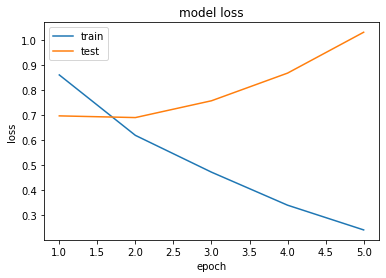

In [ ]:
# validataion data loss 변화 시각화
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()